<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Библиотеки-и-функции" data-toc-modified-id="Библиотеки-и-функции-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Библиотеки и функции</a></span></li><li><span><a href="#Загрузка-и-обзор-данных" data-toc-modified-id="Загрузка-и-обзор-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка и обзор данных</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Изменение-весов" data-toc-modified-id="Изменение-весов-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Изменение весов</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Downsampling</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#BERT-предобработка" data-toc-modified-id="BERT-предобработка-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>BERT предобработка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#BERT" data-toc-modified-id="BERT-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>BERT</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Заказчик: Интернет-магазин «Викишоп» 

Опсание: магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. 

Цель: создать инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Задача: обучить модель классифицировать комментарии на позитивные и негативные. 

Данные: набор данных с разметкой о токсичности правок.

Условия: метрики качества *F1* не ниже 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Библиотеки и функции

In [37]:
#data manipulation
import pandas as pd
import numpy as np
from pathlib import Path

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tqdm import notebook
from tqdm.notebook import tqdm
tqdm.pandas()

#text manipulation
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
stopwords = set(nltk_stopwords.words('english'))
import re

#ML
import torch
import transformers
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.set_option('max_colwidth', 200
             )
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 50)

#misc
rs = 15122021
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fomkin.ag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fomkin.ag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fomkin.ag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fomkin.ag\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fomkin.ag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Создадим необходимые для обзора и предобработки функции

In [2]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.
    
    df: Набор данных для вычисления статистики.
    return: Датафрейм со статистикой распределения пропусков.
    """
    na = df.isna().sum()
    result = pd.DataFrame(data={"Кол-во уникальных": df.nunique(),
                                "Кол-во заполненных": df.shape[0] - na,
                                "Кол-во пропусков": na,
                                "Доля пропусков, %": 100 * na / df.shape[0],
                                "Тип": df.dtypes})
    print(f"Total rows = {df.shape[0]}")
    print(f"Total NA-values = {na.sum()}")
    return result

### Загрузка и обзор данных

In [3]:
path_dir = Path("./data/")
df = pd.read_csv(Path(path_dir, 'toxic_comments.csv'))
df.head(3)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0


In [4]:
check_missings(df)

Total rows = 159571
Total NA-values = 0


,Кол-во уникальных,Кол-во заполненных,Кол-во пропусков,"Доля пропусков, %",Тип
text,159571,159571,0,0.0,object
toxic,2,159571,0,0.0,int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


### Предобработка

BERT попробуем обучить на выборке в 2000 строк

In [6]:
df_bert = df \
    .copy() \
    .sample(2000, random_state=rs) \
    .reset_index(drop=True)
df_bert.head()

,text,toxic
0,I just had to teach that loser a lesson not to mess with people's pages. That's all.,1
1,"""\n\n Forgery of IAC logo \n\nThe image on Wikipedia you proffered for Anna Hazare using IAC name contains an obvious forgery of IAC logo. As the copyright clerk please immediately arrange to get ...",0
2,"""\n\nI actually agree completely with Aïki, but I suspect you don't actually realize what he/she(?) just said. Aïki really just restated what I had written when I edited the article summary a whi...",0
3,"Please leave the birth/death dates linked. There's not any consensus at MOS to unlink them, particularly in the case of birth/death dates.",0
4,"With respect to your addition of as the source, how does this substantiate this as a work of the US government? Right now, it appears to be the work of a private photographer.",0


Взглянем на сбаланированность классов

In [7]:
balance = df.toxic.value_counts()[0] / df.toxic.value_counts()[1]
print(f'Классы несбалансированы в отношении 1 к {balance:.0f}.')

Классы несбалансированы в отношении 1 к 9.


In [16]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [24]:
lemmatizer = WordNetLemmatizer()

def clear_text(text):
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    return ' '.join(text.split())

def lemmatize(text):
    text = text.lower()
    word_list = nltk.word_tokenize(text)
    lemmed = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_list])  
    return lemmed

In [25]:
%%time
df['lemm_text'] = df['text'].apply(lemmatize)

CPU times: total: 1h 53min
Wall time: 1h 53min 3s


In [26]:
%%time
df['lemm_cleared_text'] = df['lemm_text'].apply(clear_text)

CPU times: total: 4.47 s
Wall time: 4.47 s


In [27]:
df = df \
    .drop(['text', 'lemm_text'], axis=1) \
    .rename({'lemm_cleared_text': 'lemm_text'}, axis=1)
df.head(3)

,toxic,lemm_text
0,0,explanation why the edits make under my username hardcore metallica fan be revert they be n't vandalism just closure on some gas after i vote at new york doll fac and please do n't remove the temp...
1,0,d'aww he match this background colour i 'm seemingly stuck with thanks talk january utc
2,0,hey man i 'm really not try to edit war it 's just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the forma...


In [29]:
target = df['toxic']
corpus = df['lemm_text']

features_train, features_valid, target_train, target_valid = train_test_split(corpus, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=rs)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=rs)

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train)
features_valid = count_tf_idf.transform(features_valid)
features_test = count_tf_idf.transform(features_test)
print(f'Размер обучающей выборки: {features_train.shape}')
print(f'Размер валидационной выборки: {features_valid.shape}')
print(f'Размер тестовой выборки: {features_test.shape}')

Размер обучающей выборки: (95742, 115539)
Размер валидационной выборки: (31914, 115539)
Размер тестовой выборки: (31915, 115539)


### Борьба с дисбалансом

#### Изменение весов

In [30]:
%%time

lr = LogisticRegression()
f1_cv = cross_val_score(lr,
                     features_train,
                     target_train,
                     cv=5,
                     scoring='f1').mean()
print('F1 без балансировки: ', round(f1_cv, 2))

F1 без балансировки:  0.7
CPU times: total: 1min 14s
Wall time: 13.5 s


In [31]:
%%time
lr_b = LogisticRegression(class_weight='balanced')
f1_cv_bal = cross_val_score(lr_b, 
                            features_train,
                            target_train,
                            cv=5,
                            scoring='f1').mean()
print('F1 на сбалансированных классах: ', round(f1_cv_bal, 2))

F1 на сбалансированных классах:  0.74
CPU times: total: 1min 2s
Wall time: 10.5 s


#### Downsampling

In [32]:
train = df.iloc[target_train.index]

target_train_zeros = train[train['toxic'] == 0]['toxic']
target_train_ones = train[train['toxic'] == 1]['toxic']

target_train_zeros_downsample = target_train_zeros.sample(target_train_ones.shape[0], random_state=rs)
target_train_downsample = pd.concat([target_train_zeros_downsample, target_train_ones])

features_train_downsample = df.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample, target_train_downsample, random_state=rs)

features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text'].values.astype('U'))

In [33]:
%%time

lr_ds = LogisticRegression()
f1_cv_ds = cross_val_score(lr_ds,
                     features_train_downsample,
                     target_train_downsample,
                     cv=5,
                     scoring='f1').mean()
print('F1 после даунсемплинга: ', round(f1_cv_ds, 2))

F1 после даунсемплинга:  0.88
CPU times: total: 19.4 s
Wall time: 3.47 s


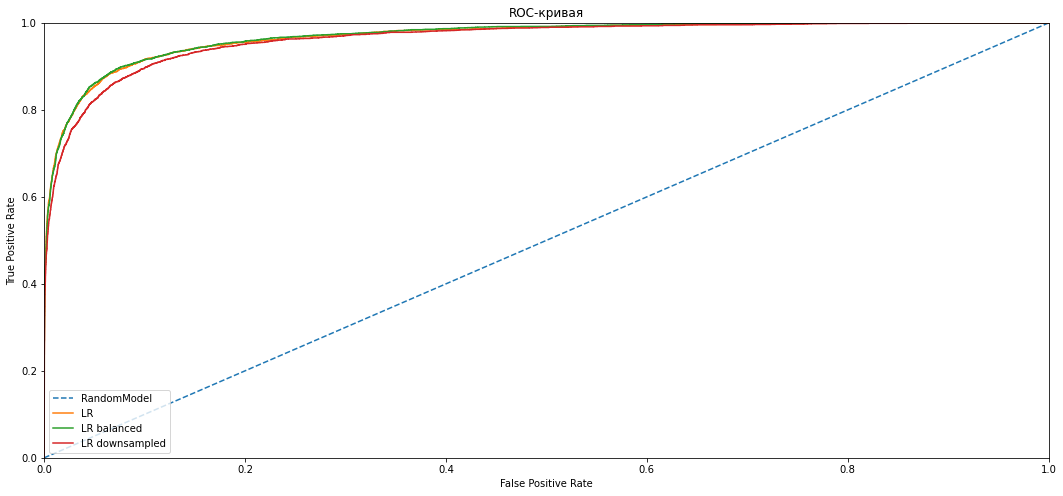

In [34]:
fig = plt.subplots(figsize=(18, 8))

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

lr = LogisticRegression()
lr.fit(features_train, target_train)
prob_valid = lr.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, prob_one_valid)
auc_roc = roc_auc_score(target_valid, prob_one_valid)
valid_f1 = f1_score(target_valid, lr.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

lr_b = LogisticRegression(class_weight='balanced')
lr_b.fit(features_train, target_train)
prob_valid = lr_b.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, prob_one_valid)
auc_roc_bal = roc_auc_score(target_valid, prob_one_valid)
valid_f1_bal = f1_score(target_valid, lr_b.predict(features_valid))
plt.plot(fpr, tpr, label='LR balanced')

lr_ds = LogisticRegression()
lr_ds.fit(features_train_downsample, target_train_downsample)
prob_valid = lr_ds.predict_proba(features_valid)
prob_one_valid = prob_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, prob_one_valid)
auc_roc_ds = roc_auc_score(target_valid, prob_one_valid)
valid_f1_ds = f1_score(target_valid, lr_ds.predict(features_valid))
plt.plot(fpr, tpr, label='LR downsampled')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower left')

plt.title("ROC-кривая")
plt.show()

In [35]:
data = {'F1_Cross':[f1_cv,
              f1_cv_bal,
              f1_cv_ds],
        'F1_valid':[valid_f1,
                    valid_f1_bal,
                    valid_f1_ds],
        'AUC-ROC':[auc_roc,
                   auc_roc_bal,
                   auc_roc_ds]
}
index =['Standard', 'Balanced Classes', 'Downsampled']

score = pd.DataFrame(data=data, index=index).sort_values(by='F1_valid', ascending=False)
score

,F1_Cross,F1_valid,AUC-ROC
Balanced Classes,0.742686,0.753520,0.968936
Standard,0.696909,0.730147,0.967845
Downsampled,0.882120,0.697399,0.962402


## Обучение

### BERT предобработка

In [23]:
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')

# Загрузка предобученной модели/токенизатора 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
tokenized = df_bert['text'].progress_apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

  0%|          | 0/2000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (729 > 512). Running this sequence through the model will result in indexing errors


In [25]:
tokens = []
target = []

for i in range(len(tokenized)):
    if len(tokenized[i]) <= 512:
        tokens.append(tokenized[i])
        target.append(df_bert['toxic'][i])
        
tokens = (pd.Series(tokens))[:2000]
target = (pd.Series(target))[:2000]

max_len = 0
for i in tqdm(tokens.values):
    if len(i) > max_len:
        max_len = len(i)

  0%|          | 0/1962 [00:00<?, ?it/s]

In [26]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tqdm(tokens.values)])
mask = np.where(padded != 0, 1, 0)

if padded.shape == mask.shape:
    print('Выборки равны, переходим к эмбеддингам')
else:
    print('Что-то пошло не так')

  0%|          | 0/1962 [00:00<?, ?it/s]

Выборки равны, переходим к эмбеддингам


In [30]:
batch_size = 200
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
features_bert = np.concatenate(embeddings)

  0%|          | 0/9 [00:00<?, ?it/s]

### Обучение

In [36]:
def teacher(model, features, target):
    model.fit(features, target)
    F1_train = f1_score(target, model.predict(features))
    F1_valid = f1_score(target_valid, model.predict(features_valid))
    df_res = pd.DataFrame([(type(model).__name__), F1_train, F1_valid]).T
    df_res.columns = ['model', 'f1_train', 'f1_valid']
    return df_res

In [42]:
def param_search(models, params):
    grid = GridSearchCV(model, params, cv=3)
    grid.fit(features_train, target_train)
    display(grid.best_params_,
            grid.best_score_)
    return grid.best_params_

In [ ]:
model = XGBClassifier()
xgb_params = {'n_estimators': range(100, 301, 50),
              'max_depth': range(9,16, 2),
              'learning_rate': [0.2, 0.5],
}
best_params = param_search(model, xgb_params)

In [35]:
xgb = XGBClassifier(n_estimators=300, max_depth=15, learning_rate = 0.5, random_state = rs)
xgb_res = teacher(xgb, features_train, target_train)
xgb_res

,model,f1_train,f1_valid
0,XGBClassifier,0.956947,0.779006


In [32]:
lr = LogisticRegression(class_weight='balanced')
lr_res = teacher(lr, features_train, target_train)
lr_res

,model,f1_train,f1_valid
0,LogisticRegression,0.837062,0.750429


In [33]:
cbc = CatBoostClassifier(iterations = 250, learning_rate = 0.5, eval_metric = 'F1', verbose = True, random_state = rs)
cbc_res = teacher(cbc, features_train, target_train)
cbc_res

0:	learn: 0.4147750	total: 1.15s	remaining: 4m 46s
1:	learn: 0.4824589	total: 2.17s	remaining: 4m 29s
2:	learn: 0.5052712	total: 3.38s	remaining: 4m 38s
3:	learn: 0.5645150	total: 4.52s	remaining: 4m 38s
4:	learn: 0.5882853	total: 5.54s	remaining: 4m 31s
5:	learn: 0.5942203	total: 6.55s	remaining: 4m 26s
6:	learn: 0.6019104	total: 7.55s	remaining: 4m 22s
7:	learn: 0.6039326	total: 8.57s	remaining: 4m 19s
8:	learn: 0.6092243	total: 9.58s	remaining: 4m 16s
9:	learn: 0.6089220	total: 10.7s	remaining: 4m 16s
10:	learn: 0.6240033	total: 11.7s	remaining: 4m 13s
11:	learn: 0.6346114	total: 12.7s	remaining: 4m 11s
12:	learn: 0.6402239	total: 13.7s	remaining: 4m 10s
13:	learn: 0.6443583	total: 14.7s	remaining: 4m 8s
14:	learn: 0.6476216	total: 15.7s	remaining: 4m 6s
15:	learn: 0.6574422	total: 16.8s	remaining: 4m 5s
16:	learn: 0.6602254	total: 17.9s	remaining: 4m 5s
17:	learn: 0.6625553	total: 19s	remaining: 4m 5s
18:	learn: 0.6663994	total: 20.1s	remaining: 4m 4s
19:	learn: 0.6700406	total: 21

,model,f1_train,f1_valid
0,CatBoostClassifier,0.832619,0.765478


In [34]:
lgbm = LGBMClassifier(n_estimators=300, max_depth=15, learning_rate = 0.5, random_state = rs)
lgbm_res = teacher(lgbm, features_train, target_train)
lgbm_res

,model,f1_train,f1_valid
0,LGBMClassifier,0.981493,0.767155


In [36]:
result = lr_res.append([cbc_res, lgbm_res, xgb_res])
result.f1_train = result.f1_train.astype('float').round(2)
result.f1_valid = result.f1_valid.astype('float').round(2)
result = result.sort_values(by='f1_valid', ascending=False)
result

,model,f1_train,f1_valid
0,LogisticRegression,0.837062,0.750429
0,CatBoostClassifier,0.832619,0.765478
0,LGBMClassifier,0.981493,0.767155
0,XGBClassifier,0.956947,0.779006


In [67]:
result

,model,f1_train,f1_valid
0,LogisticRegression,0.84,0.75
0,CatBoostClassifier,0.83,0.77
0,LGBMClassifier,0.98,0.77
0,XGBClassifier,0.96,0.78


### BERT

Разделим "бертовые выборки"

In [38]:
target_bert = target.head(len(features_bert))
features_train_bert, features_test_bert, target_train_bert, target_test_bert = train_test_split(features_bert,
                                                       target_bert,
                                                       test_size = 0.3,
                                                       random_state = rs)

Обучим лог.регрессию и сделаем предсказание на бертовых выборках

In [48]:
lr_bert = LogisticRegression(max_iter = 1000)
lr_bert.fit(features_train_bert, target_train_bert)
F1_cv = cross_val_score(lr_bert, features_train_bert, target_train_bert, cv = 3, scoring = 'f1').mean()
F1_cv_val = cross_val_score(lr_bert, features_test_bert, target_test_bert, cv = 3, scoring = 'f1').mean() 
df_res = pd.DataFrame(['LogRegBert', F1_cv, F1_cv_val]).T
df_res.columns = ['model', 'f1_train', 'f1_valid']
df_res

,model,f1_train,f1_valid
0,LogRegBert,0.554546,0.600145


In [ ]:
result.append(lr_bert)
result

### Выводы 

Мы обучили несколько моделей, рещающих задачу классификации: 
* LGBMClassifier
* CatBoostClassifier
* XGBClassifier
* LogisticRegression
* LogisticRegression, обученную на BERT

Для BERT мы взяли ограниченную выборку из 2000 строк, поэтому модель показала себя недостаточно хорошо.<br>
Тем не менее, лучшей моделью согласно сравнению метрик F1, признаем **XGBClassifier** с показателем 0.78 на валиде. 

## Тестирование

In [40]:
def tester(model, features, target):
    model.fit(features, target)
    F1_train = f1_score(target, model.predict(features))
    F1_test = f1_score(target_test, model.predict(features_test))
    df_res = pd.DataFrame([(type(model).__name__), F1_train, F1_test]).T
    df_res.columns = ['model', 'f1_train', 'f1_test']
    return df_res

In [41]:
best = XGBClassifier(n_estimators=250, max_depth=11, max_leaves=1, learning_rate=0.2, booster='gbtree', random_state = rs)
best_res = tester(best, features_train, target_train)
best_res

,model,f1_train,f1_test
0,XGBClassifier,0.874626,0.751611


## Выводы

Классификатор **XGBoost** достиг качества предсказания требуемого значения метрики F1=0.75.<br>

В ходе исследования:
1. Проведена предобработка данных;
2. Протестировано 2 способа балансировки классов, выбран способ изменения весов.
3. Обучено несколько моделей, в том числе обученная на данных, обработанных с помощью нейронной сети BERT. 
    В условиях ограниченности времени и ресурсов модель не отработала на полную мощность, в следствие чего принята не была.
4. По итогам метрики F1 выбрана и протестирована модель градиентого бустинга **XGBoost**, решающая задачу классификации для обнаружения токсичных комментариев.
5. Результат метрики F1 модели XGBoost = 0.75, что соответствует требуемому уровню заказчика.

☔☔☔